In [4]:
!pip install seaborn
!pip install newspaper3k
import nltk
nltk.download('all')

     |████████████████████████████████| 215kB 2.7MB/s 
     |████████████████████████████████| 51kB 5.5MB/s 
     |████████████████████████████████| 7.4MB 8.1MB/s 
     |████████████████████████████████| 194kB 39.6MB/s 
  Created wheel for jieba3k: filename=jieba3k-0.35.1-cp36-none-any.whl size=7398406 sha256=84d4480dc1c3b9333ca40d643d945e6cf7f618806d1c539b47b1dc8bccc6f340
  Stored in directory: /root/.cache/pip/wheels/83/15/9c/a3f1f67e7f7181170ad37d32e503c35da20627c013f438ed34
  Created wheel for tinysegmenter: filename=tinysegmenter-0.3-cp36-none-any.whl size=13539 sha256=21a7ef05c692dfe5591c73807b5b4f1b72c82b1ab55263aa3127a944f6e44550
  Stored in directory: /root/.cache/pip/wheels/81/2b/43/a02ede72324dd40cdd7ca53aad718c7710628e91b8b0dc0f02
  Created wheel for feedfinder2: filename=feedfinder2-0.0.4-cp36-none-any.whl size=3357 sha256=c260e9b2700f89cd802834c1029f635bfd7422affaba9c97ec236bd7e5dba84a
  Stored in directory: /root/.cache/pip/wheels/de/03/ca/778e3a7a627e3d98836cc890e7cb40c

True

The next two lines are required to load files from your Google drive.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


# SCRAPER

In [0]:
from newspaper import Article
from newspaper import ArticleException
import newspaper
# from progress.bar import IncrementalBar
import time
import string


def scrape_news_links(url):
    '''
        Scrapes links : not only google but any online vendor.
        set url while calling the function
    '''
    paper = newspaper.build(url, memoize_articles=False)
    links = []
    # bar = IncrementalBar('Scraping Links', max=len(paper.articles), suffix='%(percent)d%%')
    for article in paper.articles:
        links.append(article.url)
        # bar.next()
        time.sleep(0.1)
    # bar.finish()
    
    # print(links)
    return links

def clean_text(text):
    '''
        To clean text
    '''
    # print('cleaning_text')
    # text = text.strip()
    # text = text.lower()
    # for punct in string.punctuation:
    #     text = text.replace(punct, '')
    text = text.lower()
    strin = text.split('\n')
    text = " ".join(strin)
    # text.replace('\\', '')
    exclude = set(string.punctuation)
    text = ''.join(ch for ch in text if ch not in exclude)
    return text

def get_content(links):
    '''
        get headlines and news content
    '''
    # print('getting content')
    content = []
    # next_bar = IncrementalBar('Getting Content', max=)
    # bar = IncrementalBar('Getting content & Cleaning text', max=len(links), suffix='%(percent)d%%' )
    for url in links:
        try:
            article = Article(url, language='en')
            article.download()
            article.parse()
            title = clean_text(article.title)
            news = clean_text(article.text)
            if title != None:
                if news != None: 
                    if news != ' ': 
                        if news != '':      # for sites which news content cannot be scraped
                            content.append([title, news])
            # bar.next()
    
        except ArticleException as ae:
            # if 'Article \'download()\' failed' in ae:
            continue
    
    # bar.finish()
    return content
    

def scraper(link='https://timesofindia.indiatimes.com/'):
    '''
        aggregator function
    '''
    # print('scraper_main')5
    return get_content(scrape_news_links(link))

# if __name__ == "__main__":
    # links = scrape_google_links()
    # print(get_content(links[:15]))

# DF AND CSV

In [0]:
import csv
import pandas as pd



LINKS = ['https://timesofindia.indiatimes.com/', 'https://www.thehindu.com/', 'https://www.bbc.com/news', 'https://www.theguardian.co.uk/']

def create_df(content_list):
    '''
        To write the data to csv file
        takes a list of list where the inner list contains ['headline', 'news']
    '''
    title = []
    news = []
    print('creating_dataFrame')

    for content in content_list:
        title.append(content[0])
        news.append(content[1])
        # keywords.append(content[2])

    data = {'Title' : title, 'News' : news}
    df = pd.DataFrame(data, columns=['Title', 'News'])
    return df


def df_to_csv(df, filename='NewsCluster.csv'):
    '''
        writes dataframe to csv
    '''
    print('writing_to_csv')
    df.to_csv('/content/drive/My Drive/data/' + filename)


def create_csv():
    '''
        aggregator function of this module
    '''
    print('create_csv_main')
    content_list = []
    for link in LINKS:
        content_list.append(scraper(link))

    content_lst = []
    for content in content_list:
        for cont in content:
            content_lst.append(cont)
    # content_lst = scraper()
    # print(content_lst)
    try:
        num = int(input('Enter the number of articles to be stored : '))
        if num < 15:
            raise ValueError('Provide a larger number for dataset')
        df_to_csv(create_df(content_lst[:num]))
    except ValueError as ve:
        df_to_csv(create_df(content_lst))


# CONVERT TO DB

In [0]:
import sqlite3
from sqlite3 import IntegrityError
import csv

def insert_to_db(tup):
    with sqlite3.connect('/content/drive/My Drive/data/NEWS.DB') as con:
        cur = con.cursor()
        cur.execute("INSERT INTO content (headlines, news) VALUES(?, ?);", tup)
        con.commit()

def to_database():
    '''
        converts csv to db
    '''
    with sqlite3.connect('/content/drive/My Drive/data/NEWS.DB') as con:
        cur = con.cursor()
        cur.execute('CREATE TABLE IF NOT EXISTS content(headlines TEXT, news TEXT PRIMARY KEY);')
        with open('/content/drive/My Drive/data/NewsCluster.csv', encoding='utf-8') as fin:
            dr = csv.DictReader(fin)
            for i in dr:
                try:
                    tup = (i['Title'], i['News'])
                    insert_to_db(tup)
                except IntegrityError as ie:
                    # if 'unique constraint' in ie:
                    continue

            # to_db = [(i['Title'], i['News']) for i in dr]
        
        # cur.executemany("INSERT INTO content (headlines, news) VALUES(?, ?);", to_db)
        con.commit()
    con.close()

def print_db():
    '''
        prints database
        used for reference and verification
    '''
    with sqlite3.connect("/content/drive/My Drive/data/NEWS.DB") as con:
        cur = con.cursor()
        cur.execute('SELECT * FROM content')
        return cur.fetchall()

# if __name__ == "__main__":
    '''
    execute either of the functions to update database or displahy the content
    '''
    # to_database()
    # print(print_db()[0])

# CALL SCRAPER, CREATE CSV and DB

In [0]:
create_csv()
to_database()

create_csv_main
Enter the number of articles to be stored : 
creating_dataFrame
writing_to_csv


# CHECK CSV

In [0]:
import csv
def print_csv(filename):
  with open('/content/drive/My Drive/data/'+filename) as csv_file:
      csv_reader = csv.reader(csv_file, delimiter=',')
      for row in csv_reader:
        print(row)

        
if __name__ == '__main__':
    print_csv("NewsCluster.csv")

['', 'Title', 'News']
['0', 'in the darkness of the pandemic the kindnesses of eid shine brighter than ever', 'amidst everything that covid19 has transformed dramatically today eidulfitr is top of the mind as it brings the muslim holy month of ramzan to a close every year it is usually celebrated with large public festivities images pourover from all across india of people dressed in new clothes congregating at mosques embracing each other and feasting together but this year the eid bazaars have remained without crowds the mosques are empty and the community namaz has made way for prayers at home from kolkata to hyderabad the imams have called upon the faithful to maintain social distancing  the eid charity drives are the one activity that have picked up pace helping the underprivileged is of course a usual practice during the festival but the need is so much more naked this time around the annual zakat charity that is due during ramzan is now called for more than ever as it is not jus

# CLUSTERING

In [0]:
"""
Wrapper for offline clustering methods that do not take into
account temporal aspects of data and online clustering methods
that update and/or predict new data as it comes in. Framework
supports custom text representations (e.g. Continuous Bag of
Words) but will default to tfidf if none are provided.
"""

import numpy as np
import seaborn as sns
from sklearn.manifold import MDS
from scipy.cluster.hierarchy import ward, dendrogram
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
# from hdbscan import HDBSCAN
from sklearn.metrics.pairwise import cosine_similarity
from nltk.corpus import stopwords
from scipy.sparse import issparse, vstack
from sklearn.cluster import *
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer

nltk_stopwords = stopwords.words('english')


class Cluster:
    """ Clustering methods for text. Be cautious of datasize; in cases
    of large data, KMeans may be the only efficient choice.

    Accepts custom matrices

    Full analysis of methods can be found at:
    http://hdbscan.readthedocs.io/en/latest/comparing_clustering_algorithms.html

    Usage:
        >> with open('../data/cleaned_text.txt', 'r', encoding='utf8') as f:
               text = f.readlines()
        >> clustering = Cluster(text)
        >> results = clustering('hdbscan', matrix=None, reduce_dim=None,
                                visualize=True, top_terms=False,
                                min_cluster_size=10)
        >> print(results)
    """
    def __init__(self, text):
        """
        Args:
            text: strings to be clustered (list of strings)
        """
        self.text = list(set(text))

    def __call__(self, method, vectorizer=None,
                         reduce_dim=None, viz=False,
                         *args, **kwargs):
        """
        Args:
            method: algorithm to use to cluster data (str)
            vectorizer: initialized method to convert text to np array;
                        assumes __call__ vectorizes the text (Class, optional)
            reduce_dim: reduce dim of representation matrix (int, optional)
            visualize: visualize clusters in 3D (bool, optional)
            *args, **kwargs: see specified method function
        """

        # Make sure method is valid
        assert method in ['hdbscan', 'dbscan', 'spectral', 'kmeans',
                          'minikmeans', 'affinity_prop', 'agglomerative',
                          'mean_shift', 'birch'], 'Invalid method chosen.'

        if not hasattr(self, 'vectorizer'):
            if vectorizer is None:
                self._init_tfidf()
            else:
                self.vectorizer = vectorizer
                self.matrix = self.vectorizer(self.text)

        # Reduce dimensionality using latent semantic analysis (makes faster)
        if reduce_dim is not None:
            self.matrix = self._pca(reduce_dim, self.matrix)

        # Cache current method
        method = eval('self.' + method)
        self.algorithm = method(*args, **kwargs)
        self.results = self._organize(self.algorithm.labels_)

        # For plotting
        self.viz_matrix = self.matrix

        # Visualize clustering outputs if applicable
        if viz:
            _ = self.viz3D()
            _ = self.top_terms()

        return self.results

    # def hdbscan(self, min_cluster_size=10, prediction_data=False):
    #     """ DBSCAN but allows for varying density clusters and no longer
    #     requires epsilon parameter, which is difficult to tune.
    #     http://hdbscan.readthedocs.io/en/latest/how_hdbscan_works.html
    #     Scales slightly worse than DBSCAN, but with a more intuitive parameter.
    #     """
    #     hdbscan = HDBSCAN(min_cluster_size=min_cluster_size,
    #                         prediction_data=prediction_data)
    #     if prediction_data:
    #         return hdbscan.fit(self._safe_dense(self.matrix))
    #     else:
    #         return hdbscan.fit(self.matrix)

    def dbscan(self, eps=0.50):
        """ Density-based algorithm that clusters points in dense areas and
        distances points in sparse areas. Stable, semi-fast, non-global.
        Scales very well with n_samples, decently with n_clusters (not tunable)
        """
        dbscan = DBSCAN(eps=eps, min_samples=3)
        return dbscan.fit(self.matrix)

    def kmeans(self, n_clusters=10, n_init=5):
        km = KMeans(n_clusters=n_clusters, init='k-means++', max_iter=300, n_init=n_init, verbose=0, random_state=3425)
        return km.fit(self.matrix)

    def minikmeans(self, n_clusters=10, n_init=5, batch_size=5000):
        """ Partition dataset into n_cluster global chunks by minimizing
        intra-partition distances. Expect quick results, but with noise.
        Scales exceptionally well with n_samples, decently with n_clusters.
        """
        kmeans = MiniBatchKMeans(n_clusters=n_clusters,
                                 init='k-means++',
                                 n_init=n_init,
                                 batch_size=batch_size)
        return kmeans.fit(self.matrix)

    def birch(self, n_clusters=10):
        """ Partitions dataset into n_cluster global chunks by repeatedly
        merging subclusters of a CF tree. Birch does not scale very well to high
        dimensional data. If many subclusters are desired, set n_clusters=None.
        Scales well with n_samples, well with n_clusters.
        """
        birch = Birch(n_clusters=n_clusters)
        return birch.fit(self.matrix)

    def agglomerative(self, n_clusters=10, linkage='ward'):
        """ Iteratively clusters dataset semi-globally by starting with each
        point in its own cluster and then using some criterion to choose another
        cluster to merge that cluster with another cluster.
        Scales well with n_samples, decently with n_clusters.
        """
        agglomerative = AgglomerativeClustering(n_clusters=n_clusters,
                                                linkage=linkage)
        return agglomerative.fit(self._safe_dense(self.matrix))

    def spectral(self, n_clusters=5):
        """ Partitions dataset semi-globally by inducing a graph based on the
        distances between points and trying to learn a manifold, and then
        running a standard clustering algorithm (e.g. KMeans) on this manifold.
        Scales decently with n_samples, poorly with n_clusters.
        """
        spectral = SpectralClustering(n_clusters=n_clusters)
        return spectral.fit(self.matrix)

    def affinity_prop(self, damping=0.50):
        """ Partitions dataset globally using a graph based approach to let
        points ‘vote’ on their preferred ‘exemplar’.
        Does not scale well with n_samples. Not recommended to use with text.
        """
        affinity_prop = AffinityPropagation(damping=damping)
        return affinity_prop.fit(self._safe_dense(self.matrix))

    def mean_shift(self, cluster_all=False):
        """ Centroid-based, global method that assumes there exists some
        probability density function from which the data is drawn, and tries to
        place centroids of clusters  at the maxima of that density function.
        Unstable, but conservative.
        Does not scale well with n_samples. Not recommended to use with text.
        """
        mean_shift = MeanShift(cluster_all=False)
        return mean_shift.fit(self._safe_dense(self.matrix))

    def _init_tfidf(self, max_features=30000, analyzer='word',
                    stopwords=nltk_stopwords, token_pattern=r"(?u)\b\w+\b"):
        """ Default representation for data is sparse tfidf vectors

        Args:
            max_features: top N vocabulary to consider (int)
            analyzer: 'word' or 'char', level at which to segment text (str)
            stopwords: words to remove from consideration, default nltk (list)
        """
        # Initialize and fit tfidf vectors
        self.vectorizer = TfidfVectorizer(max_features=max_features,
                                             stop_words=stopwords,
                                             analyzer=analyzer,
                                             token_pattern=token_pattern)
        self.matrix = self.vectorizer.fit_transform(self.text)

        # Get top max_features vocabulary
        self.terms = self.vectorizer.get_feature_names()

        # For letting user know if tfidf has been initialized
        self.using_tfidf = True

    def viz2D(self, matrix=None,
                plot_kwds={'alpha':0.30, 's':40, 'linewidths':0}):
        """ Visualize clusters in 2D """
        # Run PCA over the data so we can plot
        matrix2D = self._pca(n=2, matrix=self.viz_matrix)

        # Get labels
        labels = np.unique(self.results['labels'])

        # Assign a color to each label
        palette = sns.color_palette('deep', max(labels)+1)
        colors = [palette[x] if x >= 0 else (0.0, 0.0, 0.0) for x in labels]

        # Plot the data
        plt.close()
        fig = plt.figure(figsize=(10,6))
        plt.scatter(matrix2D.T[0],
                    matrix2D.T[1],
                    c=colors,
                    **plot_kwds)
        frame = plt.gca()

        # Turn off axes, since they are arbitrary
        frame.axes.get_xaxis().set_visible(False)
        frame.axes.get_yaxis().set_visible(False)

        # Add a title
        alg_name = str(self.algorithm.__class__.__name__)
        plt.title('{0} clusters found by {1}'.format(len(labels),
                                                     alg_name),
                  fontsize=20)
        plt.tight_layout()
        plt.show()
        return fig

    def viz3D(self, matrix=None):
        """ Visualize clusters in 3D """
        # Run PCA over the data
        matrix3D = self._pca(n=3, matrix=self.viz_matrix)

        # Extract labels from results
        labels = self.results['labels']

        # Assign colors
        palette = sns.color_palette('deep', int(max(labels)+1))
        colors = [palette[x] if x >= 0 else (0.0, 0.0, 0.0) for x in labels]

        # Plot the data
        plt.close()
        fig = plt.figure(figsize=(10,6))
        ax = plt.axes(projection='3d')
        ax.scatter(matrix3D.T[0],
                   matrix3D.T[1],
                   matrix3D.T[2],
                   c=colors)

        # Add a title
        alg_name = str(self.algorithm.__class__.__name__)
        plt.title('{0} Clusters | {1} Items | {2}'.format(len(set(labels)),
                                                            matrix3D.shape[0],
                                                            alg_name),
                  fontsize=20)

        # Turn off arbitrary axis tick labels
        plt.tick_params(axis='both', left=False, top=False, right=False,
                        bottom=False, labelleft=False, labeltop=False,
                        labelright=False, labelbottom=False)
        plt.tight_layout()
        plt.show()
        return fig

    def top_terms(self, topx=10):
        """ Print out top terms per cluster. """
        if self.using_tfidf != True:
            print('For use with non-tfidf vectorizers,try sklearn NearestNeighbors\
            (although NN performs poorly with high dimensional inputs.')
            return None

        # Get labels, sort text IDs by cluster
        labels = self.results['labels']
        cluster_idx = {clust_id: np.where(labels == clust_id)[0]
                       for clust_id in set(labels)}

        # Get centers, stack into array
        centroids = np.vstack([self.viz_matrix[indexes].mean(axis=0)
                                for key, indexes in cluster_idx.items()])

        # Compute closeness of each term representation to each centroid
        order_centroids = np.array(centroids).argsort()[:, ::-1]

        # Organize terms into a dictionary
        cluster_terms = {clust_id: [self.terms[ind]
                                    for ind in order_centroids[idx, :topx]]
                        for idx, clust_id in enumerate(cluster_idx.keys())}

        # Print results
        print("Top terms per cluster:")
        for clust_id, terms in cluster_terms.items():
            words = ' | '.join(terms)
            print("Cluster {0} ({1} items): {2}".format(clust_id,
                                                        len(cluster_idx[clust_id]),
                                                        words))

        return cluster_terms

    def item_counts(self):
        """ Print number of counts in each cluster """
        for key, vals in self.results.items():
            if key == 'labels':
                continue
            print('Cluster {0}: {1} items'.format(key, len(vals)))

    def _organize(self, labels):
        """ Organize text from clusters into a dictionary """
        # Organize text into respective clusters
        cluster_idx = {clust_id: np.where(labels == clust_id)[0]
                       for clust_id in set(labels)}

        # Put results in a dictionary; key is cluster idx values are text
        results = {clust_id: [self.text[idx] for idx in cluster_idx[clust_id]]
                    for clust_id in cluster_idx.keys()}
        results['labels'] = list(labels)

        return results

    def _pca(self, n, matrix):
        """ Perform PCA on the data """
        return TruncatedSVD(n_components=n).fit_transform(matrix)

    def _safe_dense(self, matrix):
        """ Some algorithms don't accept sparse input; for these, make
        sure the input matrix is dense. """
        if issparse(matrix):
            return matrix.todense()
        else:
            return matrix


class OnlineCluster(Cluster):
    """ Online (stream) clustering of textual data. Check each method
    to determine if the model is updating or ad-hoc predicting. These are not
    'true' online methods as they preserve all seen data, as opposed to letting
    data points and clusters fade, merge, etc. over time.

    Usage:
        To initialize:
        >> with open('../data/cleaned_text.txt', 'r', encoding='utf8') as f:
               text = f.readlines()
        >> online = OnlineCluster(method='kmeans', text, visualize=True)

        To predict and update parameters if applicable:
        >> new_text = text[-10:]
        >> online.predict(new_text)
    """
    def __init__(self, text, method, *args, **kwargs):
        """
        Args:
            text: strings to be clustered (list of strings)
            method: algorithm to use to cluster (string)
            *args, **kwargs (optional):
                vectorizer: text representation. Defaults tfidf (array, optional)
                reduce_dim: reduce dim of representation matrix (int, optional)
                visualize: visualize clusters in 3D (bool, optional)
        """
        # Only accept valid arguments
        assert method in ['kmeans', 'birch', 'hdbscan',
                          'dbscan', 'mean_shift'], \
                'Method incompatible with online clustering.'

        # Initialize inherited class
        super().__init__(text)

        # Get initial results
        self.results = self.__call__(method=method, *args,**kwargs)

        # Save args, set method
        self.__dict__.update(locals())
        self.method = eval('self._' + method)

    def predict(self, new_text):
        """ 'Predict' a new example based on cluster centroids and update params
        if applicable (kmeans, birch). If a custom (non-tfidf) text representation
        is being used, class assumes new_text is already in vectorized form.

        Args:
            new_text: list of strings to predict
        """
        # Predict
        assert type(new_text) == list, 'Input should be list of strings.'
        self.text = list(set(self.text + new_text))
        new_matrix = self._transform(new_text)
        output_labels = self.method(new_matrix)

        # Update attribute for results, plotting
        self._update_results(output_labels)
        self.viz_matrix = vstack([self.viz_matrix, new_matrix])
        return output_labels

    def _kmeans(self, new_matrix):
        """ Updates parameters and predicts """
        self.algorithm = self.algorithm.partial_fit(new_matrix)
        return self.algorithm.predict(new_matrix)

    def _birch(self, new_matrix):
        """ Updates parameters and predicts """
        self.algorithm = self.algorithm.partial_fit(new_matrix)
        return self.algorithm.predict(new_matrix)

    def _hdbscan(self, new_matrix):
        """ Prediction only, HDBSCAN requires training to be done on dense
        matrices for prediction to work properly. This makes training
        inefficient, though. """
        try:
            labels, _ = approximate_predict(self.algorithm,
                                            self._safe_dense(new_matrix))
        except AttributeError:
            try:
                self.algorithm.generate_prediction_data()
                labels, _ = approximate_predict(self.algorithm,
                                                self._safe_dense(new_matrix))
            except ValueError:
                print('Must (inefficiently) re-train with prediction_data=True')
        return labels

    def _dbscan(self, new_matrix):
        """ Prediction only """
        # Extract labels
        labels = self.algorithm.labels_

        # Result is noise by default
        output = np.ones(shape=new_matrix.shape[0], dtype=int)*-1

        # Iterate all input samples for a label
        for idx, row in enumerate(new_matrix):

            # Find a core sample closer than EPS
            for i, row in enumerate(self.algorithm.components_):

                # If it's below the threshold of the dbscan model
                if cosine(row, x_core) < self.algorithm.eps:

                    # Assign label of x_core to the input sample
                    output[idx] = labels[self.algorithm.core_sample_indices_[i]]
                    break

        return output

    def _mean_shift(self, new_matrix):
        """ Prediction only, not efficient """
        return self.algorithm.predict(new_matrix)

    def _transform(self, new_text):
        """ Transform text to tfidf representation. Assumes already vectorized
        if tfidf matrix has not been initialized. """
        if self.using_tfidf:
            return self.vectorizer.transform(new_text)
        else:
            return self.vectorizer(new_text)
        return new_matrix

    def _update_results(self, labels):
        """ Update running dictionary """
        new_results = self._organize(labels)
        for key in self.results.keys():
            try:
                self.results[key] += new_results[key]
            except KeyError:
                continue





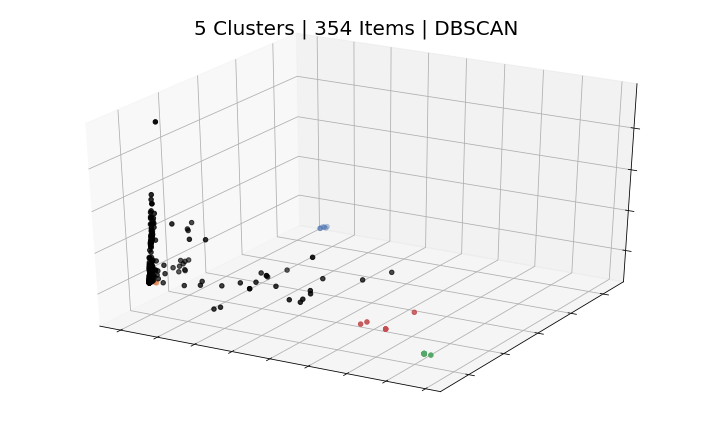

Top terms per cluster:
Cluster 0 (8 items): times | 2020 | films | best | india | kannada | bengali | marathi | bollywood | tamil
Cluster 1 (4 items): business | technology | sport | zuckerberg | enveloping | environment | epidemic | episode | episodes | esport
Cluster 2 (17 items): entertainment | events | politics | latest | news | mumbai | kochi | visakhapatnam | hyderabad | coimbatore
Cluster 3 (6 items): updates | live | events | politics | latest | news | kerala | karnataka | telangana | states
Cluster -1 (319 items): coronavirus | video | news | lockdown | new | us | cummings | india | pictures | dominic


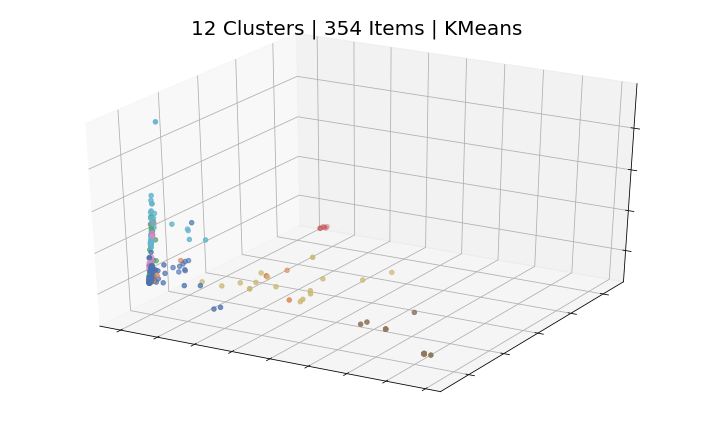

Top terms per cluster:
Cluster 0 (194 items): video | us | covid19 | global | lockdown | trump | australia | life | years | back
Cluster 1 (5 items): videos | actors | news | actresses | movies | films | bollywood | watch | cinema | songs
Cluster 2 (22 items): new | could | coronavirus | claims | cast | video | study | cause | critics | rule
Cluster 3 (8 items): times | 2020 | films | best | india | kannada | bengali | marathi | bollywood | tamil
Cluster 4 (6 items): guardian | securely | contact | book | puzzles | faqs | subscription | android | introducing | ios
Cluster 5 (23 items): events | politics | latest | news | entertainment | updates | live | puducherry | hyderabad | thiruvananthapuram
Cluster 6 (13 items): cummings | dominic | johnson | boris | pressure | video | defending | 260mile | faces | tory
Cluster 7 (10 items): business | uk | air | sport | technology | lockdown | delivery | teas | turns | cream
Cluster 8 (17 items): news | bbc | world | india | latest | breaking | 

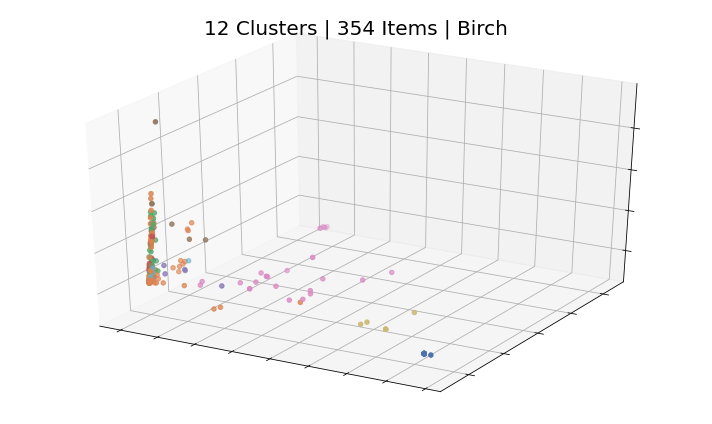

Top terms per cluster:
Cluster 0 (16 items): us | global | australia | trade | canada | astronauts | launch | spacex | education | parts
Cluster 1 (192 items): coronavirus | covid19 | business | video | trump | technology | years | pandemic | village | get
Cluster 2 (46 items): video | new | coronavirus | lockdown | could | uk | explainer | end | 5g | huawei
Cluster 3 (11 items): cummings | dominic | boris | johnson | pressure | defending | 260mile | tory | faces | trip
Cluster 4 (7 items): tv | pm | film | earthquake | best | hindi | shows | live | new | books
Cluster 5 (15 items): coronavirus | state | distancing | japan | emergency | social | glance | stories | cases | take
Cluster 6 (28 items): news | india | films | best | times | 2020 | bbc | latest | world | videos
Cluster 7 (5 items): guardian | securely | contact | book | faqs | puzzles | subscription | android | ios | introducing
Cluster 8 (6 items): updates | live | events | politics | latest | news | kerala | karnataka | te

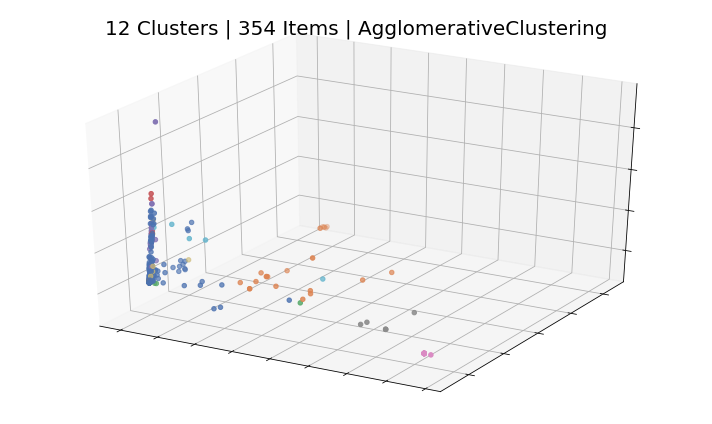

Top terms per cluster:
Cluster 0 (247 items): video | coronavirus | us | lockdown | covid19 | trump | tv | global | uk | australia
Cluster 1 (16 items): news | bbc | world | india | latest | breaking | movies | actresses | local | resources
Cluster 2 (6 items): business | technology | sport | groups | bridges | agree | warn | must | gadgets | announcements
Cluster 3 (5 items): life | lockdown | couples | iranian | changed | one | video | brink | families | upside
Cluster 4 (22 items): coronavirus | new | could | distancing | social | glance | stories | take | memorial | cast
Cluster 5 (5 items): guardian | securely | contact | book | faqs | puzzles | subscription | android | ios | introducing
Cluster 6 (17 items): entertainment | events | politics | latest | news | mumbai | kochi | visakhapatnam | hyderabad | coimbatore
Cluster 7 (6 items): updates | live | events | politics | latest | news | kerala | karnataka | telangana | states
Cluster 8 (6 items): pictures | week | window | view |

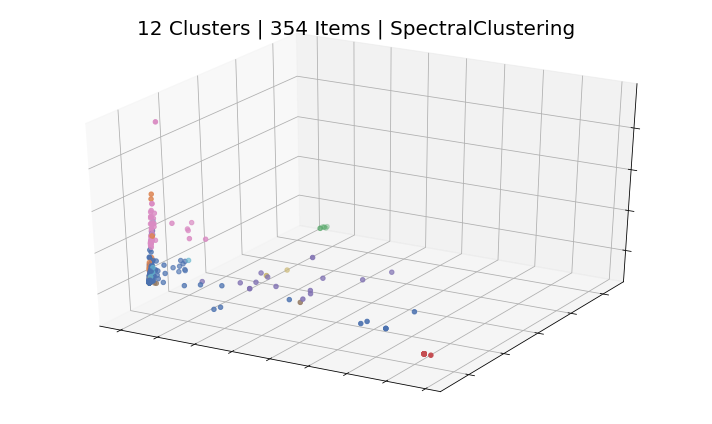

Top terms per cluster:
Cluster 0 (227 items): video | us | new | covid19 | lockdown | trump | guardian | tv | global | uk
Cluster 1 (11 items): cummings | dominic | boris | johnson | pressure | defending | 260mile | tory | faces | trip
Cluster 2 (8 items): times | 2020 | films | best | india | kannada | bengali | marathi | bollywood | tamil
Cluster 3 (17 items): entertainment | events | politics | latest | news | mumbai | kochi | visakhapatnam | hyderabad | coimbatore
Cluster 4 (15 items): news | bbc | world | india | latest | breaking | local | resources | online | oneminute
Cluster 5 (5 items): business | technology | sport | gadgets | announcements | products | news | breaking | updates | events
Cluster 6 (51 items): coronavirus | lockdown | state | could | new | japan | emergency | video | home | vaccine
Cluster 7 (2 items): wilsons | paulette | 50 | windrush | jamaica | years | journey | visit | video | europe
Cluster 8 (3 items): movies | actresses | actors | news | films | bolly

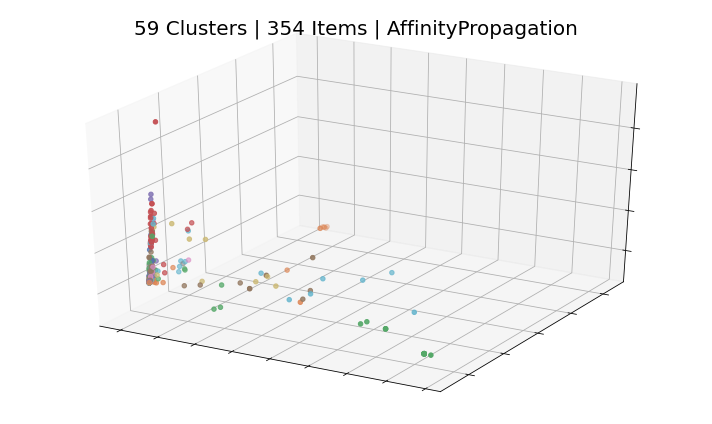

Top terms per cluster:
Cluster 0 (6 items): east | middle | scotland | fears | body | much | eid | building | timber | grenfell
Cluster 1 (6 items): business | technology | sport | groups | bridges | agree | warn | must | gadgets | announcements
Cluster 2 (6 items): tv | check | film | reality | best | hindi | shows | music | heard | youve
Cluster 3 (8 items): dreams | mean | boiling | like | prospered | tough | small | businesses | midinterview | quake
Cluster 4 (9 items): one | iranian | changed | couples | life | lockdown | coronavirus | parkour | athlete | kiss
Cluster 5 (2 items): south | living | sky | protester | korean | samsung | korea | behind | doors | baseball
Cluster 6 (3 items): caribbean | america | latin | eclipse | solar | prepares | august | north | outbreak | tourism
Cluster 7 (2 items): left | campervan | argentina | evicted | uber | driver | die | home | coronavirus | eternally
Cluster 8 (4 items): biden | joe | trump | sexual | assault | quiet | allegation | radic

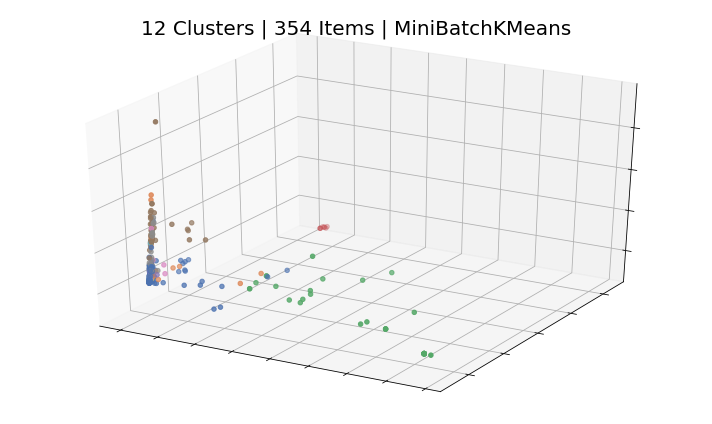

Top terms per cluster:
Cluster 0 (182 items): business | guardian | global | video | australia | tv | us | technology | cummings | america
Cluster 1 (4 items): home | coronavirus | drivethrough | creates | care | visit | evicted | uber | driver | left
Cluster 2 (38 items): news | latest | events | politics | entertainment | updates | live | india | breaking | bbc
Cluster 3 (8 items): times | 2020 | films | best | india | kannada | bengali | marathi | bollywood | tamil
Cluster 4 (4 items): say | critics | rule | foul | tirade | people | end | could | lord | hall
Cluster 5 (43 items): coronavirus | lockdown | state | could | emergency | japan | new | claims | glance | stories
Cluster 6 (13 items): new | us | china | canada | video | zealand | war | earthquake | kongs | pm
Cluster 7 (34 items): video | cummings | johnson | dominic | lockdown | boris | life | explainer | win | coronavirus
Cluster 8 (9 items): trump | says | work | sessions | controversy | tees | plays | qualified | general

In [14]:


from matplotlib import pyplot as plt
import pandas as pd
import string

cluster_dict = {2:'dbscan', 3:'spectral', 4:'kmeans', 5:'affinity_prop', 6:'agglomerative', 7:'mean_shift', 8:'birch'}

def clean(text):
    '''
        Clean text before running clusterer
    '''
    text = text.strip()
    text = text.lower()
    for punct in string.punctuation:
        text = text.replace(punct, ' ')
    lst = text.split()
    text = " ".join(lst)
    for t in text:
        if t not in string.printable:
            text = text.replace(t, '')
    return text

def clust():
    df = pd.read_csv('/content/drive/My Drive/data/NewsCluster.csv')
    data = df["Title"].tolist()

    data = [clean(dt) for dt in data ]

    # for dt in data:
    #     data[data.index(dt)] = clean(dt)

    data = pd.DataFrame(data, columns=["text"])
    data['text'].dropna(inplace=True)

    # %matplotlib inline


    clustering = Cluster(data.text)
    results = clustering(method='dbscan', vectorizer=None, 
                        reduce_dim=None, viz=True, eps=0.9)
    
    results = clustering(method='kmeans', vectorizer=None, 
                        reduce_dim=None, viz=True, n_clusters=12)
    
    results = clustering(method='birch', vectorizer=None, 
                        reduce_dim=None, viz=True, n_clusters=12)
    
    results = clustering(method='agglomerative', vectorizer=None, 
                        reduce_dim=None, viz=True, n_clusters=12)
    
    results = clustering(method='spectral', vectorizer=None, 
                        reduce_dim=None, viz=True, n_clusters=12)
    
    results = clustering(method='affinity_prop', vectorizer=None, 
                        reduce_dim=None, viz=True, damping=0.5)
    
    results = clustering(method='minikmeans', vectorizer=None, 
                        reduce_dim=None, viz=True, n_clusters=12)
    
    
    
    # clustering = Cluster(data.text)
    # for i in range(2,9):
    #     print(cluster_dict[i])
    #     if i == 4:
    #         result = clustering(cluster_dict[i])
    #     else:
    #         result = clustering(cluster_dict[i])
        
    #     print(result)

clust()



